# KNN Model for predicting Age with Energy - Vibration

### Import libraries

In [1]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.signal import find_peaks
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
# import openpyxl

### Import Tools Functions

Readwav function

In [2]:
from Functions.readAllFileVibration import readAllFileVibration

# P1 = readAllFileVibration("../../Data_Clean/Chanel0_Data_Columns/P1_clean")

Spectrum

In [3]:
from Functions.spectrumFromSignal import spectrumFromSignal

# print(P1)

# testData = P1[0][1].to_numpy()
# # print(testData)
# testDataSpectrum, freqTest = spectrumFromSignal(testData, 20000)

Plot Spectrum

In [4]:
from Functions.plot_spectrum_with_freq import plot_spectrum_with_freq

# Example usage
# plot_spectrum_with_freq(testDataSpectrum, freqTest, title="Spectrum of Test Data")


Energy

In [5]:
def energy_per_frequency_band_from_spectrum(spectrum, freqs, band_width):
    # Calculate energy per band
    band_energies = []
    band_frequencies = []
    for start_freq in range(0, int(freqs[-1]), band_width):
        end_freq = start_freq + band_width
        band_indices = np.where((freqs >= start_freq) & (freqs < end_freq))[0]
        band_energy = np.sum(spectrum[band_indices]**2)  # Sum of squared magnitudes
        band_energies.append(band_energy)
        band_frequencies.append((start_freq + end_freq) / 2)  # Center frequency of the band

    return band_energies, band_frequencies

# energy_per_frequency_band_from_spectrum(testDataSpectrum,freqTest,50)

# Main

In [6]:
raquetteTypeList = {"RB":0,"RO":1,"RR":2,"RV":3}
raquetteAgeList = {"P1":1,"P2":2,"P3":3}



sampleRateFolderP1=[]
sampleRateFolderP2=[]
sampleRateFolderP3=[]

P1=readAllFileVibration("../../Data_Clean/Chanel0_Data_Columns/P1_clean")
P2=readAllFileVibration("../../Data_Clean/Chanel0_Data_Columns/P2_clean")
P3=readAllFileVibration("../../Data_Clean/Chanel0_Data_Columns/P3_clean")

print(len(P1),len(P2),len(P3))


# Combine all data into a single DataFrame with equal repartition of ages
all_data = []

# Find the minimum number of samples across all ages
min_samples_per_age = min(len(P1), len(P2), len(P3))

# Limit the data for each age to the minimum number of samples
for dataset, age in zip([P1[:min_samples_per_age], P2[:min_samples_per_age], P3[:min_samples_per_age]], ["P1", "P2", "P3"]):
    for item in dataset:
        label, df = item  # Unpack the tuple
        spectrum_points,freqs = spectrumFromSignal(np.array(df), 20000)
        all_data.append({
            "Spectrum": spectrum_points,
            "Label": label,
            "Age": age
        })

# Convert the list of dictionaries into a DataFrame
df_combined = pd.DataFrame(all_data)
print(df_combined)




216 324 255
                                              Spectrum Label Age
0    [5415.435319490299, 3187.673624625387, 2567.48...    RB  P1
1    [3574.0039456266313, 2253.172677296551, 2189.4...    RB  P1
2    [4336.317505980091, 2636.183071505374, 2297.29...    RB  P1
3    [7218.047965980523, 4371.60331681831, 3234.473...    RB  P1
4    [6351.72555524914, 3431.4594161592727, 3006.71...    RB  P1
..                                                 ...   ...  ..
643  [5836.786813198334, 5338.783594267168, 4861.72...    RV  P3
644  [5622.544885395455, 5094.665026104518, 4655.36...    RV  P3
645  [5630.589450958037, 5045.113429470839, 4640.37...    RV  P3
646  [4352.537884533889, 3104.609413841152, 3005.97...    RV  P3
647  [5811.7086478063, 5341.56190848496, 5060.81685...    RV  P3

[648 rows x 3 columns]


In [7]:
# Define the band width
band_width = 20

# Compute energy per band for each row in the DataFrame
df_combined['EnergyPerBand'] = df_combined['Spectrum'].apply(
    lambda spectrum: energy_per_frequency_band_from_spectrum(np.array(spectrum), freqs, band_width)[0]
)

print(df_combined)

                                              Spectrum Label Age  \
0    [5415.435319490299, 3187.673624625387, 2567.48...    RB  P1   
1    [3574.0039456266313, 2253.172677296551, 2189.4...    RB  P1   
2    [4336.317505980091, 2636.183071505374, 2297.29...    RB  P1   
3    [7218.047965980523, 4371.60331681831, 3234.473...    RB  P1   
4    [6351.72555524914, 3431.4594161592727, 3006.71...    RB  P1   
..                                                 ...   ...  ..   
643  [5836.786813198334, 5338.783594267168, 4861.72...    RV  P3   
644  [5622.544885395455, 5094.665026104518, 4655.36...    RV  P3   
645  [5630.589450958037, 5045.113429470839, 4640.37...    RV  P3   
646  [4352.537884533889, 3104.609413841152, 3005.97...    RV  P3   
647  [5811.7086478063, 5341.56190848496, 5060.81685...    RV  P3   

                                         EnergyPerBand  
0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29326939.6...  
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12773504.2...  
2    [0.0, 0

In [8]:
# Combine features into X
X = np.array([
    np.concatenate((energy_band, freqs[:len(energy_band)]))
    for energy_band in df_combined["EnergyPerBand"].tolist()
])
# X=np.array(X_AmplitudeAllWavFile)


# Encode string labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_combined["Age"])

# # print(y)
# print(len(X),len(y))

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(X,y)


In [9]:
# Définir les bonnes valeurs trouvé
n_neighbors = 10  # Nombre de voisins
weights_options = ['uniform']  # Méthode de pondération
metric_options = ['manhattan']  # Métriques


# Définir les plages de valeurs pour les hyperparamètres
n_neighbors_range = range(1, 21)  # Nombre de voisins
weights_options = ['uniform', 'distance']  # Méthode de pondération
metric_options = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']  # Métriques

# Liste pour stocker les résultats
results = []


# Tester toutes les combinaisons d'hyperparamètres
for n_neighbors in n_neighbors_range:
    for weights in weights_options:
        for metric in metric_options:
            # Créer et entraîner le modèle KNN
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
            knn.fit(X_train, y_train)

            # Évaluer sur l'ensemble de test
            y_pred = knn.predict(X_test)
            accuracy_test = accuracy_score(y_test, y_pred)

            # Évaluer sur l'ensemble d'entraînement
            y_train_pred = knn.predict(X_train)
            accuracy_train = accuracy_score(y_train, y_train_pred)

            # Ajouter les résultats à la liste
            results.append({
                'n_neighbors': n_neighbors,
                'weights': weights,
                'metric': metric,
                'accuracy_train': accuracy_train,
                'accuracy_test': accuracy_test
            })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)



print(results_df)

     n_neighbors   weights     metric  accuracy_train  accuracy_test
0              1   uniform  euclidean        1.000000       0.907692
1              1   uniform  manhattan        1.000000       0.946154
2              1   uniform  chebyshev        1.000000       0.838462
3              1   uniform  minkowski        1.000000       0.907692
4              1  distance  euclidean        1.000000       0.907692
..           ...       ...        ...             ...            ...
155           20   uniform  minkowski        0.795367       0.823077
156           20  distance  euclidean        1.000000       0.869231
157           20  distance  manhattan        1.000000       0.853846
158           20  distance  chebyshev        1.000000       0.815385
159           20  distance  minkowski        1.000000       0.869231

[160 rows x 5 columns]


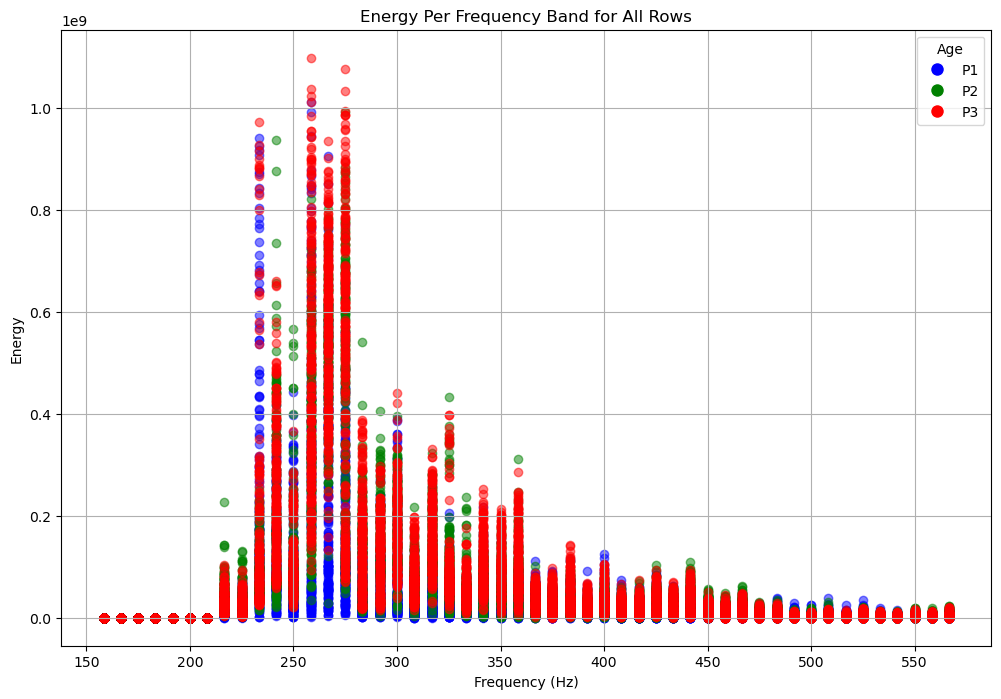

In [10]:
# Define a color map for each age
age_color_map = {"P1": "blue", "P2": "green", "P3": "red"}

# Iterate through all rows in the DataFrame
plt.figure(figsize=(12, 8))
for index, row in df_combined.iterrows():
    energy_per_band = row['EnergyPerBand']
    band_frequencies = freqs[:len(energy_per_band)]
    age = row['Age']
    plt.scatter(band_frequencies, energy_per_band, color=age_color_map[age], label=f"Age {age}" if index == 0 else "", alpha=0.5)

# Add labels and title
plt.title("Energy Per Frequency Band for All Rows")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Energy")
plt.grid()
# Add a legend for the colors
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=age) for age, color in age_color_map.items()]
plt.legend(handles=handles, title="Age", loc='upper right')
plt.show()

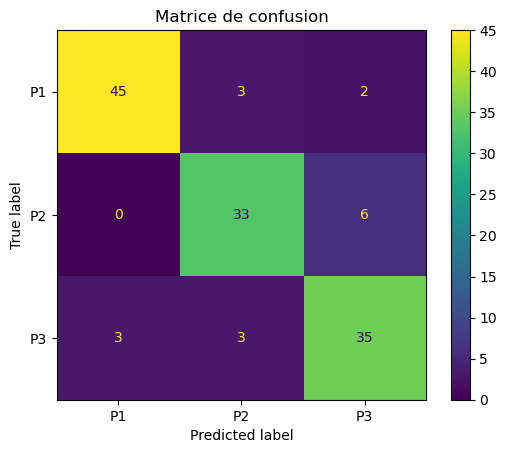

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()
